---
#1. Preparation
##1.1 Download Stable-Diffusion Checkpoint

In [3]:
%%shell
mkdir -p pretrained/
cd pretrained/
wget https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4-full-ema.ckpt
cd ..

--2023-08-02 06:45:38--  https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4-full-ema.ckpt
Resolving huggingface.co (huggingface.co)... 13.35.7.5, 13.35.7.57, 13.35.7.38, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.5|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/4c/37/4c372b4ebb57bbd02e68413d4951aa326d4b3cfb6e62db989e529c6d4b26fb21/14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sd-v1-4-full-ema.ckpt%3B+filename%3D%22sd-v1-4-full-ema.ckpt%22%3B&Expires=1691217939&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MTIxNzkzOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy80Yy8zNy80YzM3MmI0ZWJiNTdiYmQwMmU2ODQxM2Q0OTUxYWEzMjZkNGIzY2ZiNmU2MmRiOTg5ZTUyOWM2ZDRiMjZmYjIxLzE0NzQ5ZWZjMGFlOGVmMDMyOTM5MWFkNDQzNmZlYjc4MWI0MDJmNGZlY2U0ODgzYzdhZD

##1.2 Clone CelebBasis Code from [GitHub](https://github.com/ygtxr1997/CelebBasis/tree/main)

In [43]:
!git clone https://github.com/ygtxr1997/CelebBasis.git
!cd CelebBasis/ && git pull

fatal: destination path 'CelebBasis' already exists and is not an empty directory.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), 398 bytes | 79.00 KiB/s, done.
From https://github.com/ygtxr1997/CelebBasis
   9284fad..ac5cf25  main       -> origin/main
Updating 9284fad..ac5cf25
Fast-forward
 configs/stable-diffusion/aigc_id_colab_own.yaml | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


## 1.3 Prepare Training Images

In [15]:
# @title Use Your Own Images? { display-mode: "form" }

use_own_images = True # @param ["False", "True"] {type:"raw"}
print('Use Your Own Images:', use_own_images, type(use_own_images))

if use_own_images:
  in_ori_folder = "../datasets/one_shot/ori/"
  in_crop_folder = "../datasets/one_shot/ffhq"
  in_pickle = "../datasets/one_shot/ffhq.pickle"
  config_file = "./configs/stable-diffusion/aigc_id_colab_own.yaml"
else:
  in_ori_folder = "../datasets/stylegan/stylegan3-r-ffhq-1024x1024/"
  in_crop_folder = "../datasets/stylegan/ffhq"
  in_pickle = "../datasets/stylegan/ffhq.pickle"
  config_file = "./configs/stable-diffusion/aigc_id_colab_stylegan.yaml"

Use Your Own Images: True <class 'bool'>


/content
====== Uploaded your images. One image per identity. ======


Saving a_woman.png to a_woman.png
Saving joepenna_00002.png to joepenna_00002.png
total 464K
-rw-r--r-- 1 root root 282K Aug  2 08:02 a_woman.png
-rw-r--r-- 1 root root 177K Aug  2 08:02 joepenna_00002.png
====== The images uploaded to: ./datasets/one_shot/ori/ . ======


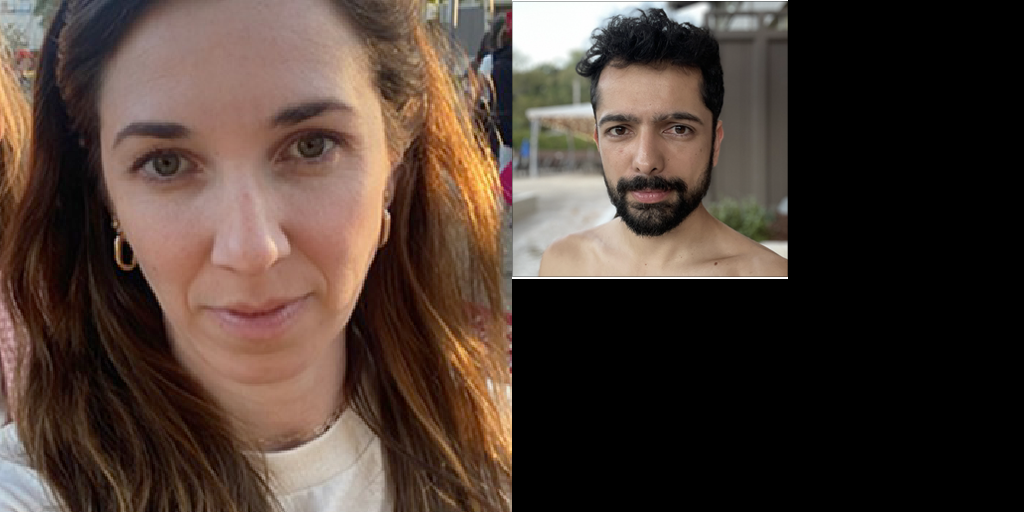

In [44]:
#@title If Yes, Use Your Own Uploaded Images (Default: two images at least)
#@markdown The examples images are from [GitHub/DreamBooth-Stable-Diffusion](https://github.com/JoePenna/Dreambooth-Stable-Diffusion).

from PIL import Image
from google.colab import files
import os

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  # get max size
  w, h = imgs[0].size
  for img in imgs:
    _w, _h = img.size
    w = max(w, _w)
    h = max(h, _h)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

%cd /content/
!cd CelebBasis && rm -r $in_ori_folder
one_shot_folder = "./datasets/one_shot/ori/"
!mkdir -p $one_shot_folder

grid = None
if use_own_images:
  print(f"====== Uploaded your images. One image per identity. ======")
  uploaded = files.upload()
  in_images = []
  for fn in uploaded.keys():
    os.system(f"mv {fn} {one_shot_folder}")
    in_images.append(Image.open(os.path.join(one_shot_folder, fn)))
  !ls -hlrt $one_shot_folder
  grid = image_grid(in_images, 1, len(in_images))
  print(f"====== The images uploaded to: {one_shot_folder} . ======")

grid

In [8]:
#@title If No, Use StyleGAN Dataset

if not use_own_images:
  # dataset
  !mkdir -p ./datasets/ && cd ./datasets/ && wget -q https://huggingface.co/datasets/ygtxr1997/CelebBasis/resolve/main/stylegan.tar
  !cd ./datasets/ && tar -xf stylegan.tar && rm stylegan.tar

### *(Optional) Copy StyleGAN Datasets and Third-Party Pretrained Weights from Your Own Google Drive*
*If you have any downloading problem in (Step 1.3), you can copy the datasets and pretrained models to your own Google Drive as follows.*

You should first copy [CelebBasis Google Drive](https://drive.google.com/drive/folders/181pJ3Y2Ffk0R8jVcErPT611aWQLCz7D9?usp=sharing) to your own [Google Drive](https://drive.google.com/drive/my-drive).
The Google Drive directory tree will be like:
```shell
My Drive/
 |--CelebBasis/
  |--datasets/
  |--pretrained/
```
Then, the following cell mounts your own Google Drive to this Colab Notebook and copies the datasets and weights files from the mounted folder.

In [9]:
# @title Use Googgle Drive? { display-mode: "form" }

use_google_drive = False # @param ["False", "True"]
print('Use Google Drive:', use_google_drive)
if use_google_drive:
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  os.system('cp -r /content/drive/MyDrive/CelebBasis/datasets/ ./')
  os.system('cp -r /content/drive/MyDrive/CelebBasis/pretrained/* ./pretrained/')
  drive.flush_and_unmount()
  os.system('cd ./datasets && tar -xf stylegan.tar && rm stylegan.tar')
  os.system('cp ./pretrained/PIPNet/* ./CelebBasis/evaluation/face_align/PIPNet/weights')
  os.system('mkdir -p ./CelebBasis/weights/')
  os.system('cp -r ./pretrained/glint360k_cosface_r100_fp16_0.1/ ./CelebBasis/weights/')
else:
  pass

Use Google Drive: False


## 1.4 Download Third-Party Pretrained Weights from HuggingFace

In [28]:
# face alignment model
!mkdir -p ./pretrained/PIPNet/ && mkdir -p ./pretrained/glint360k_cosface_r100_fp16_0.1/
!cd ./pretrained/PIPNet/ && wget -q https://huggingface.co/datasets/ygtxr1997/CelebBasis/resolve/main/PIPNet/FaceBoxesV2.pth && wget -q https://huggingface.co/datasets/ygtxr1997/CelebBasis/resolve/main/PIPNet/epoch59.pth
!cp ./pretrained/PIPNet/* ./CelebBasis/evaluation/face_align/PIPNet/weights
# face recognition model
!cd ./pretrained/glint360k_cosface_r100_fp16_0.1/ && wget -q https://huggingface.co/datasets/ygtxr1997/CelebBasis/resolve/main/glint360k_cosface_r100_fp16_0.1/backbone.pth
!mkdir -p ./CelebBasis/weights/
!cp -r ./pretrained/glint360k_cosface_r100_fp16_0.1/ ./CelebBasis/weights/

^C
^C


## 1.5 Use PIP to Install the Python Dependencies and Uninstall the Needless Modules (which are preinstalled by Google Colab but not used)

In [29]:
!pip install blinker==1.6.2 --ignore-installed
!pip uninstall -r ./CelebBasis/requirements_uninstall.txt -y
!mkdir -p pip_installed/ && cd pip_installed/ && pip install -r ../CelebBasis/requirements.txt
!pip list |grep torch

  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
^C
Obtaining clip from git+https://github.com/openai/CLIP.git@a1d071733d7111c9c014f024669f959182114e33#egg=clip (from -r ../CelebBasis/requirements.txt (line 18))
  Skipping because already up-to-date.
  Preparing metadata (setup.py) ... done
Obtaining taming_transformers from git+https://github.com/CompVis/taming-transformers.git@3ba01b241669f5ade541ce990f7650a3b8f65318#egg=taming_transformers (from -r ../CelebBasis/requirements.txt (line 141))
  Skipping because already up-to-date.
  Preparing metadata (setup.py) ... done
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, 

---
#2. Crop and Align Faces

In [45]:
!cd CelebBasis && rm -r $in_crop_folder
!cd CelebBasis && chmod +x *.sh && bash ./00_align_face.sh $in_ori_folder $in_crop_folder

/content/CelebBasis/evaluation/face_align/PIPNet/FaceBoxesV2/utils/build.py:13: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.core import setup
running build_ext
skipping 'nms/cpu_nms.c' Cython extension (up-to-date)
/content/CelebBasis
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
alignment model loaded


#3. Train
* Limited by Google Colab V100 GPU Memory ($<$16GB), we have to **modify** the `configs/stable-diffusion/aigc_id_colab_{own/stylegan}.yaml` as follows:
```yaml
model:
  params:
    personalization_config:
      params:
        momentum: 0.9  # default: 0.99
data:
  params:
    batch_size: 1  # default: 2
    num_workers: 2  # default: 8
lightning:
  modelcheckpoint:
    params:
      every_n_train_steps: 400  # default: 200
  callbacks:
    image_logger:
      params:
        batch_frequency: 1200  # default: 600
  trainer:
    max_steps: 800  # default: 1600
```
* These modifications may increase the training time and **downgrade** the performance slightly.

* You can also personalize the config file **as you need** follow our [instructions](https://github.com/ygtxr1997/CelebBasis#1-personalization) on GitHub.

In [57]:
!cd CelebBasis/ && bash ./01_start_train.sh ../pretrained/sd-v1-4-full-ema.ckpt $config_file

Global seed set to 23
Running on GPUs 0,
Loading model from ../pretrained/sd-v1-4-full-ema.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.12.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.22.self_attn.out_proj.bias', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.5.self_attn.v_proj.weight', 'vision_mod

#4. Test
Modify the following `"trainingYYYY-MM-DDTHH-MM-SS_celebbasis/"` to the project folder under `./CelebBasis/logs/` and run the test.

In [58]:
# @title Choose a project folder from the following list:  { display-mode: "form" }

print('=' * 10, ' Choose a project folder from the following list ', '=' * 10)
!ls -hlrt ./CelebBasis/logs/

==========  Choose a project folder from the following list  ==========
total 16K
drwxr-xr-x 6 root root 4.0K Aug  2 07:09 training2023-08-02T07-00-11_celebbasis
drwxr-xr-x 6 root root 4.0K Aug  2 07:48 training2023-08-02T07-38-00_celebbasis
drwxr-xr-x 6 root root 4.0K Aug  2 08:14 training2023-08-02T08-04-48_celebbasis
drwxr-xr-x 6 root root 4.0K Aug  2 08:55 training2023-08-02T08-46-12_celebbasis


In [59]:
# @title Choose your project folder to be tested: { display-mode: "form" }

logs_folder = "./CelebBasis/logs/"
project_list = os.listdir(logs_folder)

# Test settings
project_folder = "trainingYYYY-MM-DDTHH-MM-SS_celebbasis" # @param {type:"string"}
prompt_file = "./infer_images/example_prompt.txt"  # @param {type:"string"}
batch_size = 4 # @param {type:"number"}
test_step = 1599 # @param {type:"number"}

if not os.path.exists(os.path.join(logs_folder, project_folder)):
  print(f"[Warning] {project_folder} not exists, change to the latest {project_list[-1]}")
  project_folder = project_list[-1]

# Start testing
print('=' * 10, ' testing ', '=' * 10)
#!cd CelebBasis && bash ./02_start_test.sh "../pretrained/sd-v1-4-full-ema.ckpt" $prompt_file $project_folder $batch_size $test_step

# Show images
out_folder = os.path.join("./CelebBasis/outputs/", project_folder)
print(f"====== Images generated to {out_folder}. ======")
out_list = list(filter(lambda x: '.jpg' in x, os.listdir(out_folder)))
out_list.sort()

out_images = []
with open(os.path.join("./CelebBasis", prompt_file)) as f:
  out_len = len(f.readlines())
for fn in out_list[-out_len:]:
  out_images.append(Image.open(os.path.join(out_folder, fn)))

grid = image_grid(out_images, len(out_images), 1)
grid

==========  testing  ==========
logs/training2023-08-02T08-46-12_celebbasis/configs/training2023-08-02T08-46-12-project.yaml
embeddings_gs-1599.pt
Global seed set to 42
Loading model from ../pretrained/sd-v1-4-full-ema.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.mlp.fc2.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.bias', 'text_projection.weight', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.15.mlp.fc1.weight', 'vision_model.encoder.layers.19.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 

The generated images will be output under `./CelebBasis/outputs/trainingYYYY-MM-DDTHH-MM-SS_celebbasis/`. Enjoy it!